# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [56]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc



from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import re
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
from helper import clean_data, clean_kaggle_data, XGBoost_test, LightGBM_test, GBC_test #, scree_pca_plot

#supervised learning imports
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
import lightgbm as lgb
#from xgboost.sklearn import XGBClassifier  
import xgboost as xgb
from sklearn import pipeline as pl

#KERAS NEURAL NETWORK IMPORTS
import tensorflow as tf
from subprocess import check_output
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.optimizers import RMSprop
from keras.utils import to_categorical

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [57]:
# load in the data
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Assess Missing Data
### 1. Convert Missing Value Codes to NaNs (Done already)
        From first hand analysis, we see that most missing value corresponces were already replace with NaNs appart from the AGER_TYP column 
### 2. Assess Missing Data in Each column


In [58]:
#print(azdias.head())
#customers.head()
print(Counter(azdias['AGER_TYP']))
print(Counter(azdias['ANREDE_KZ']))
print(Counter(azdias['ALTERSKATEGORIE_GROB']))
print(Counter(azdias['FINANZ_MINIMALIST']))





Counter({-1: 677503, 2: 98472, 1: 79802, 3: 27104, 0: 8340})
Counter({2: 465305, 1: 425916})
Counter({3: 358533, 4: 228510, 2: 158410, 1: 142887, 9: 2881})
Counter({3: 256276, 5: 168863, 4: 167182, 2: 159313, 1: 139587})


In [59]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
print(azdias.shape)
#replace -1 with nan in AGER_TYP column
azdias['AGER_TYP'] = azdias['AGER_TYP'].replace(-1 , np.nan)


(891221, 366)


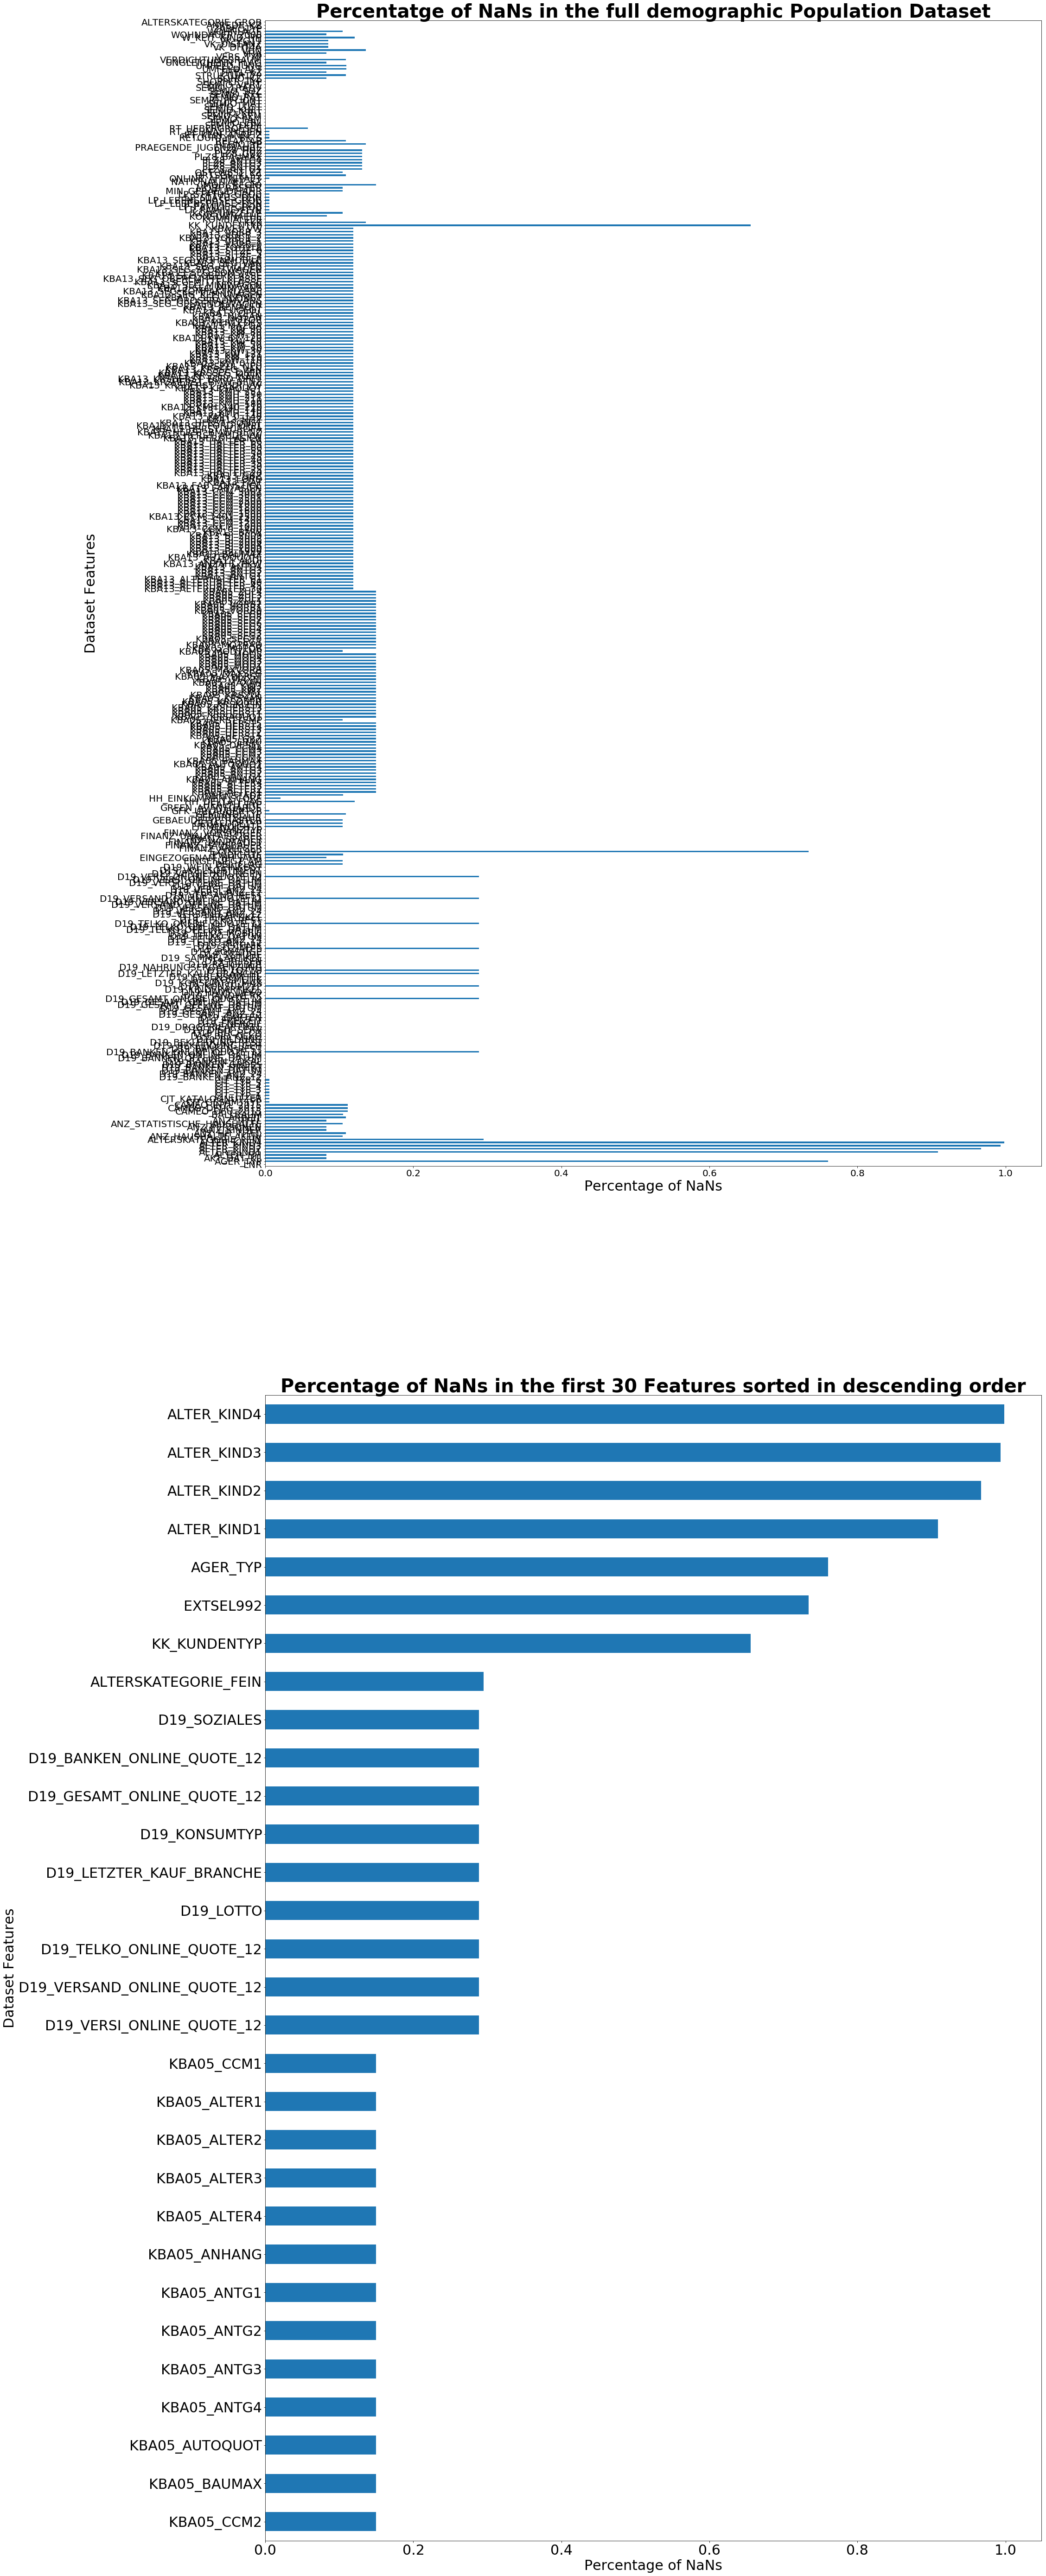

In [60]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# calculate % of nans per column
azdias_na_count = azdias.isnull().mean()
#azdias_na_per_column = azdias_na_copy.isnull().mean() 

#create figure of 2 subplots with large canvas
fig, x = plt.subplots(2,1,figsize=(30,100))


x[0].set_title("Percentatge of NaNs in the full demographic Population Dataset",fontweight="bold", size=40)
x[0].set_ylabel("Dataset Features", fontsize = 30)
x[0].set_xlabel("Percentage of NaNs", fontsize = 30)
x[0].tick_params(labelsize=20)
azdias_na_count.plot(kind='barh', ax = x[0])    # plotting on canvas

azdias_na_per_column = azdias_na_count.nlargest(30)    # making the plot more digestible
azdias_na_per_column.sort_values(ascending=True, inplace=True)    # enforce proper sorting

azdias_na_per_column.plot(kind='barh', ax = x[1])    # plotting on canvas
x[1].set_title("Percentage of NaNs in the first 30 Features sorted in descending order", fontweight="bold", size=40)
x[1].set_ylabel("Dataset Features", fontsize = 30)
x[1].set_xlabel("Percentage of NaNs", fontsize = 30)
x[1].tick_params(labelsize=30)

plt.show()

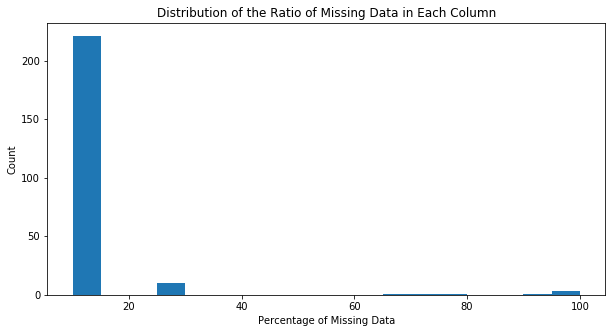

In [61]:
null_list = azdias.isnull().sum()
null_per = null_list / len(azdias)*100 

# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.title('Distribution of the Ratio of Missing Data in Each Column')
plt.hist(null_per, bins = np.linspace(10,100,19))
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Count')
plt.show()


From the graph, we notice that collumns with Nas greater that 20% are very few and can be considered as outliers in terms of NAs. We therfore drop those columns with threshold greater than 20%

In [62]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_drop_na_cols  = azdias.drop(azdias_na_per_column[azdias_na_per_column > 0.20].index, axis = 1)

azdias_drop_na_cols.shape


(891221, 349)

In [63]:
# LNR contains just unique values, just like an identifier: I contains no other usefull information
#so needs to be droped

azdias_drop_na_cols = azdias_drop_na_cols.drop(['LNR'], axis = 1)






In [64]:
#drop GROB columns and allow fein 
#NB grob are a summarrized repitition of the fein columns, thus we drop them and keep the detailed columns
azdias_drop_na_cols.drop(['LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB','LP_STATUS_GROB'], axis = 1, inplace = True)



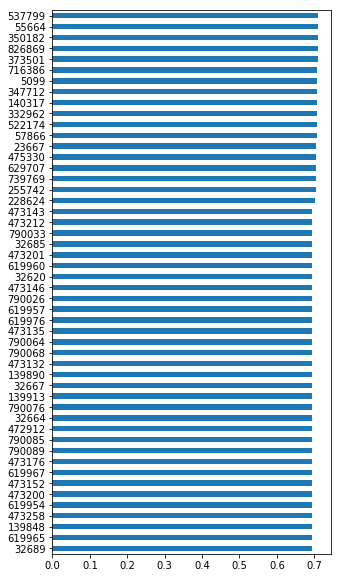

In [65]:
#Assessing missing data in each row

# How much data is missing in each row of the dataset?

azdias_na_rowcount = azdias.isnull().mean(axis = 1)
azdias_na_rowcount = azdias_na_rowcount.nlargest(n= 891221)
azdias_na_rowcount_sample = azdias_na_rowcount.nlargest(n= 50)


azdias_na_rowcount_sample.sort_values(ascending=True, inplace=True)    # enforce proper sorting
plt.subplots(figsize=(5,10))    # preparing a large canvas
azdias_na_rowcount_sample.plot(kind='barh')    # plotting on canvas
 
plt.show()


In [66]:
#Counter(azdias["CAMEO_INTL_2015"][azdias["PRAEGENDE_JUGENDJAHRE"] != np.nan])
azdias.dtypes[azdias.dtypes == 'object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [67]:
azdias.shape

(891221, 366)

In [68]:
len(azdias["CAMEO_INTL_2015"])
#deleter EINGEFUEGT_AM: it is a date time object, and information about it si not provided
#D19_LETZTER_KAUF_BRANCHE has no descriptions and will be droped as well
#CAMEO_INTL_2015 has hidden descriptions and will be re-engineered
#one hot encode OST_WEST_KZ
#one hot encode CAMEO_DEU_2015 AND CAMEO_DEUG_2015



891221

In [69]:
#Remove unwanted columns from customers
#Combine Azdias and Customer datasets then clean them together
customers_copy = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis = 1)
len_azdias, len_customers = azdias.shape[0], customers.shape[0]

combined_df = pd.concat([azdias,customers_copy])
print('Combined dataframe shape is {}'.format(combined_df.shape))

cleaned_azdias = clean_data(combined_df)

Combined dataframe shape is (1082873, 366)
Missing values for CAMER_DEUG, CAMEO_DEU and CAMEO_INTL done...
Shape after droping columns is (1082873, 359)
Missing values dropped by columns then by row done...
ANZ_KINDER, ANZ_HH_TITEL and ANZ_TITEL droped because they have too many zero values ...
LNR LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB, LP_STATUS_GROB, EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE droped ...
Praegende_jugendjahre feature engineering done ..
CAMEO_INTL_2015 feature engineering done...


C:\Users\ntsaku\Documents\DSND term2\capstone\helper.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_encoded["WOHNLAGE"][df_encoded["WOHNLAGE"]==7] = np.nan
C:\Users\ntsaku\Documents\DSND term2\capstone\helper.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_encoded["WOHNLAGE"][df_encoded["WOHNLAGE"]==8] = np.nan


numerical encoding finished...
Categorical encoding of PLZ8_BAUMAX, ARBEIT, AKT_DAT_KL, OST_WEST_KZ, CAMEO_DEU_2015, CAMEO_DEUG_2015  done...
Imputation finished...


In [70]:
cleaned_azdias, cleaned_customers = cleaned_azdias.iloc[:len_azdias], cleaned_azdias.iloc[len_azdias:]

In [71]:
print(cleaned_azdias.shape)
print(cleaned_customers.shape)


(891221, 430)
(191652, 430)


In [72]:
%%time
# Fit_transform the data
cleaned_azdias.fillna(0, inplace=True)
scaler = StandardScaler()
cleaned_azdias[cleaned_azdias.columns] = scaler.fit_transform(cleaned_azdias)

Wall time: 2min 40s


In [73]:
cleaned_azdias.head()

,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
0,0.009216,-0.101146,-0.030327,0.067434,-0.028855,0.009719,-1.026536,1.117151,-1.734841,-1.570135,...,-0.232215,-0.155333,-0.239313,-0.244726,-0.269113,-0.193896,-0.271665,-0.230659,-0.309751,-0.274807
1,-1.485423,1.750050,0.186961,0.239889,0.327822,0.892970,0.859460,-1.568161,1.196358,1.291946,...,-0.232215,-0.155333,-0.239313,-0.244726,-0.269113,-0.193896,-0.271665,-0.230659,-0.309751,-0.274807
2,0.837645,0.814222,0.119346,-0.663136,-0.040822,-1.043432,-0.397871,-0.896833,0.463558,0.576425,...,-0.232215,-0.155333,-0.239313,-0.244726,-0.269113,-0.193896,-0.271665,-0.230659,-0.309751,-0.274807
3,0.291041,-0.121606,-0.489188,-1.566162,-0.409466,-0.075231,-1.026536,-0.225505,-1.002041,-0.854615,...,-0.232215,-0.155333,-0.239313,-0.244726,-0.269113,-0.193896,-0.271665,-0.230659,-0.309751,-0.274807
4,1.247599,0.112351,-0.353958,2.045941,-0.335738,-1.043432,0.859460,-0.225505,-0.269241,-0.139095,...,-0.232215,-0.155333,-0.239313,-0.244726,-0.269113,-0.193896,-0.271665,-0.230659,-0.309751,-0.274807


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [74]:
# Investigate the variance accounted for by each principal component.
def scree_plot_pca(fit_pca):
    num_components = len(fit_pca.explained_variance_ratio_)
    ind = np.arange(num_components)

    vals = fit_pca.explained_variance_ratio_
    #print(vals)
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(1,1,1)
    cumvals = np.cumsum(vals)

    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
     #   ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

    plt.show()

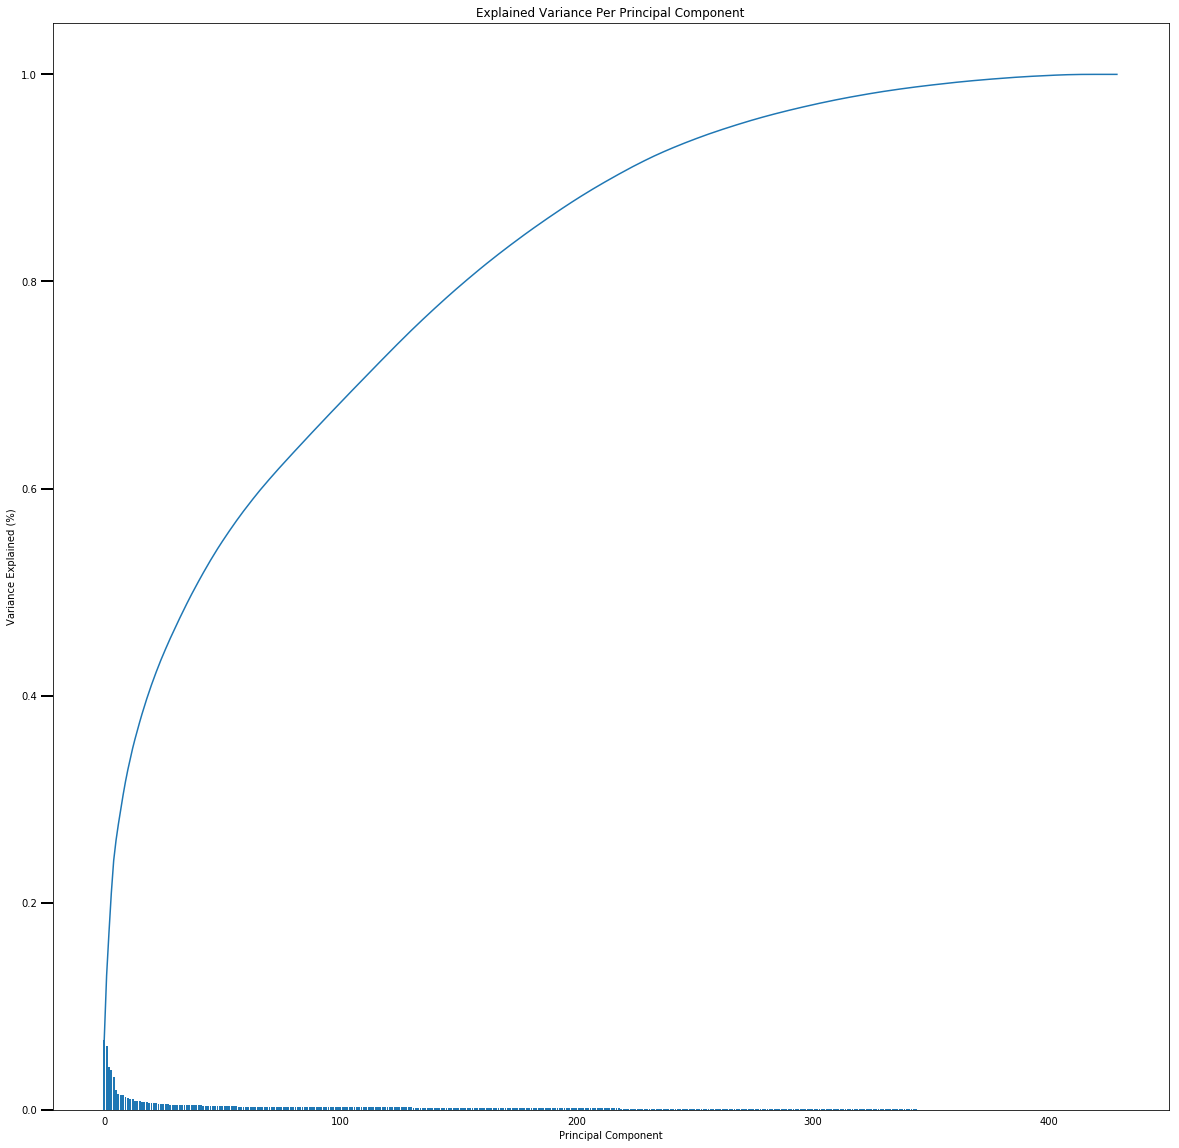

Wall time: 50.9 s


In [75]:



%%time
pca = PCA()
fit_pca = pca.fit(cleaned_azdias)
pca_result = pca.transform(cleaned_azdias)
scree_plot_pca(fit_pca)

In [76]:
cleaned_azdias.shape

(891221, 430)

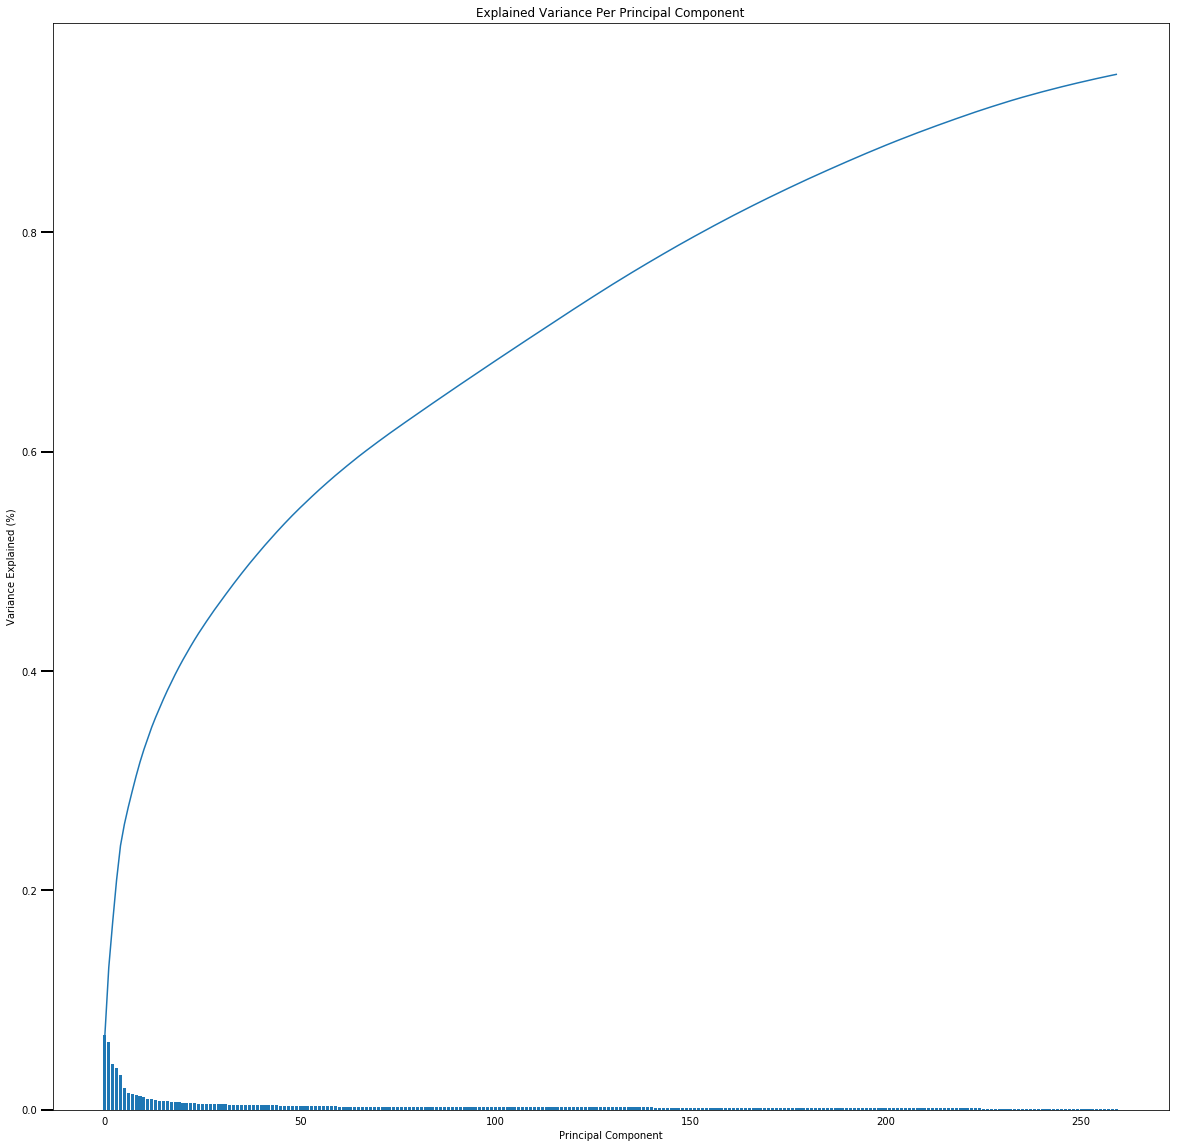

Wall time: 2min 1s


In [77]:
%%time
pca = PCA(260)
fit_pca = pca.fit(cleaned_azdias)
pca_result = pca.transform(cleaned_azdias)
scree_plot_pca(fit_pca)

In [78]:
# Map weights for the second principal component to corresponding feature names
def pca_components_eval(weights, columns):
    weight_col_map =pd.Series(weights, index = columns)
    return weight_col_map.nlargest(len(weights))

# Map weights for the first principal component to corresponding feature names
features_to_weights = pca_components_eval(pca.components_[1], cleaned_azdias.columns)
    
# and then print the linked values, sorted by weight.
print(features_to_weights)


KBA05_SEG6                 0.178800
KBA05_KRSOBER              0.163514
KBA05_KRSVAN               0.160946
KBA05_KRSZUL               0.159758
KBA05_ANHANG               0.155270
KBA05_SEG8                 0.153749
KBA05_SEG7                 0.152918
KBA05_SEG9                 0.152889
KBA05_MOD8                 0.151258
KBA05_MOTRAD               0.150529
KBA05_KRSKLEIN             0.149614
KBA05_MOTOR                0.145416
KBA05_AUTOQUOT             0.144026
KBA05_SEG10                0.143764
KBA05_SEG1                 0.142536
KBA05_DIESEL               0.142443
KBA05_KW3                  0.138796
KBA05_SEG5                 0.138255
KBA05_CCM4                 0.137969
KBA05_MOD1                 0.137769
KBA05_KRSAQUOT             0.137576
KBA05_MAXSEG               0.136505
KBA05_MAXVORB              0.133319
KBA05_KRSHERST1            0.131342
KBA05_CCM3                 0.128567
KBA05_MAXBJ                0.127801
KBA05_VORB0                0.124202
KBA05_HERST2               0

In [79]:
%%time
scores = []
for k in range(1,21):
    #cluster = KMeans(k)
    cluster = MiniBatchKMeans(k)
    azdias_cluster = cluster.fit(pca_result)
    scores.append(abs(azdias_cluster.score(pca_result)))

Wall time: 1min 46s


[361943550.38885796, 345131998.11182886, 335607169.56093466, 315055005.58724576, 338928356.07081991, 323381552.47928739, 313710082.55062193, 320353138.29083937, 302037814.10778117, 312613897.30414748, 291115921.69014305, 324575562.14873272, 302847666.3267805, 296021811.40124452, 288959214.63280886, 292909085.09059894, 284026633.11873245, 287616863.9403587, 284390620.45635378, 288708137.66982472]


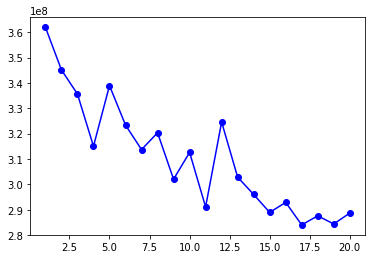

In [80]:
centers = np.linspace(1,20,20)
print(scores)
plt.plot(centers, scores, linestyle='-', marker='o', color='blue')

Text(0.5,0,'Number of Clusters')

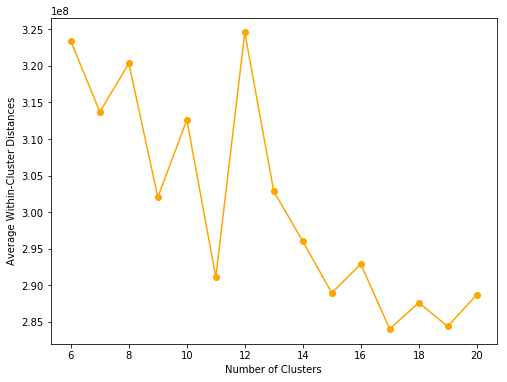

In [81]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(8, 6))
plt.plot(centers[-15:], scores[-15:], linestyle='-', marker='o', color='orange')

plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [82]:
%%time
kmeans_k = KMeans(15)
model_k = kmeans_k.fit(pca_result)
prediction_azdias = model_k.predict(pca_result) 

Wall time: 17min 31s


In [83]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleaned_customers.fillna(0, inplace = True)
cleaned_customers[cleaned_customers.columns] = scaler.transform(cleaned_customers)
customers_pca = fit_pca.transform(cleaned_customers)
customers_predict_clusters = model_k.predict(customers_pca)


Counter({7: 50996, 2: 46814, 1: 25014, 6: 18376, 0: 14652, 4: 13132, 11: 4986, 14: 4796, 13: 3971, 10: 3045, 12: 2577, 3: 1417, 8: 932, 5: 746, 9: 198}) and Counter({3: 103254, 1: 96021, 6: 93223, 2: 83792, 4: 71238, 7: 67409, 5: 64160, 14: 59208, 13: 55929, 12: 50597, 10: 49982, 0: 46866, 11: 33971, 8: 14784, 9: 787})
Here
Counter({7: 50996, 2: 46814, 1: 25014, 6: 18376, 0: 14652, 4: 13132, 11: 4986, 14: 4796, 13: 3971, 10: 3045, 12: 2577, 3: 1417, 8: 932, 5: 746, 9: 198})
Counter({3: 103254, 1: 96021, 6: 93223, 2: 83792, 4: 71238, 7: 67409, 5: 64160, 14: 59208, 13: 55929, 12: 50597, 10: 49982, 0: 46866, 11: 33971, 8: 14784, 9: 787})
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[46866, 96021, 83792, 103254, 71238, 64160, 93223, 67409, 14784, 787, 49982, 33971, 50597, 55929, 59208]


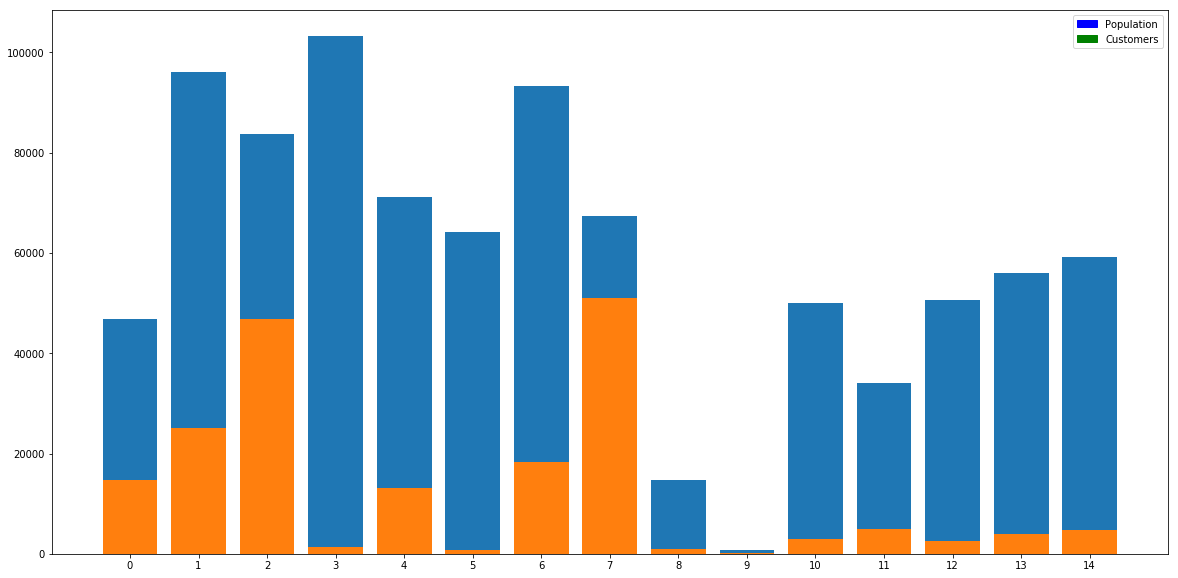

In [84]:
import matplotlib.patches as mpatches
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
print("{} and {}".format(Counter(customers_predict_clusters), Counter(prediction_azdias)))
l_azdias = Counter(prediction_azdias)
l_customers = Counter(customers_predict_clusters)
clusters = list(range(0,15))
azdias_count = []
customer_count = []
for azdias_item, customer_item in zip(sorted(l_azdias.items()),sorted(l_customers.items())):
    azdias_count.append(azdias_item[1])
    customer_count.append(customer_item[1])

plt.figure(figsize=(20,10))
print('Here')
print(l_customers)
print(l_azdias)

print(clusters)
print(azdias_count)


plt.bar(clusters, azdias_count, align='center')
plt.bar(clusters, customer_count, align='center')
plt.xticks(range(len(l_azdias)), clusters)
orange_patch = mpatches.Patch(color='green', label='Customers')
blue_patch = mpatches.Patch(color='blue', label='Population')
plt.legend(handles=[blue_patch, orange_patch])

#for item in list(l.items()):
plt.show()


In [85]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepresented_customers = [item for item in sorted(l_customers.items()) if item[1] > 5000 ]
print(overrepresented_customers)

underrepresented_customers = [item for item in sorted(l_customers.items()) if item[0] == 6 ] 


d =  list(l_azdias.values())




[(0, 14652), (1, 25014), (2, 46814), (4, 13132), (6, 18376), (7, 50996)]


In [86]:
#overrepresented df
df_prediction_customers = pd.DataFrame(customers_predict_clusters, columns = ['Cluster'])
#customers.iloc[customers_predict_clusters == 8]
target_list = df_prediction_customers[df_prediction_customers['Cluster'] == 8].index
overrep_df =customers.iloc[target_list]
overrep_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
244,167237,-1,7.0,0.0,NaN,NaN,NaN,NaN,NaN,19.0,...,5.0,6.0,3.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
398,45402,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,57.0,...,5.0,6.0,9.0,3.0,6,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
443,119630,1,9.0,12.0,NaN,NaN,NaN,NaN,12.0,6.0,...,2.0,6.0,9.0,7.0,3,FOOD,SINGLE_BUYER,0,2,3
510,5701,-1,9.0,0.0,NaN,NaN,NaN,NaN,0.0,18.0,...,7.0,6.0,9.0,5.0,3,FOOD,MULTI_BUYER,0,2,3
1043,185945,2,1.0,12.0,NaN,NaN,NaN,NaN,12.0,14.0,...,4.0,6.0,9.0,4.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4


In [87]:
#underrepresented df
df_prediction_customers = pd.DataFrame(customers_predict_clusters, columns = ['Cluster'])
#customers.iloc[customers_predict_clusters == 8]
target_list = df_prediction_customers[df_prediction_customers['Cluster'] == 6].index
underrep_df =customers.iloc[target_list]
underrep_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
14,102239,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,9.0,...,3.0,6.0,7.0,3.0,4,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
21,110328,2,7.0,11.0,NaN,NaN,NaN,NaN,11.0,29.0,...,7.0,6.0,5.0,7.0,4,FOOD,SINGLE_BUYER,0,1,4
28,5573,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,10.0,...,1.0,6.0,9.0,5.0,3,COSMETIC,MULTI_BUYER,0,2,4


In [88]:
def plot_comparison(column):
    sns.set(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    sns.countplot(x = column, data=overrep_df, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution of overrepresented population',fontsize= 20)
    sns.countplot(x = column, data=underrep_df, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('Distribution of underrepresented population', fontsize= 20)
    fig.tight_layout()
    plt.show()

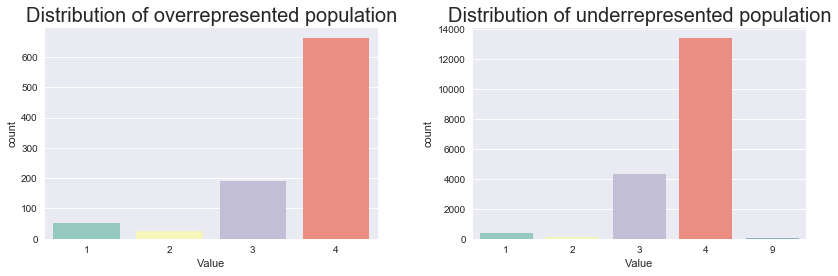

In [89]:
plot_comparison('ALTERSKATEGORIE_GROB')

In [90]:
def reconstruct_original_dataspace(point):
    """
    Output centroid coordinates in original featurespace
    """
    invert_pca = pca.inverse_transform(point)
    invert_scaling = scaler.inverse_transform(invert_pca)
    return invert_scaling


In [91]:
columns = []
centroids = []
for item in overrepresented_customers:
    centroids.append(reconstruct_original_dataspace(model_k.cluster_centers_[item[0]]))
    columns.append("centroid_"+str(item[0]))

d = pd.DataFrame(centroids, columns =  cleaned_customers.columns , index = columns )

d= d.transpose().round(2)
print(d)
print(d.shape)

                            centroid_0  centroid_1  centroid_2  centroid_4  \
ALTER_HH                          9.49        8.32       10.01       16.20   
ALTERSKATEGORIE_FEIN             12.69       10.69       12.89       15.98   
ANZ_HAUSHALTE_AKTIV               6.68        2.34        7.77        1.94   
ANZ_PERSONEN                      1.51        1.50        1.78        2.82   
ANZ_STATISTISCHE_HAUSHALTE        6.12        2.27        7.12        1.79   
BALLRAUM                          2.93        5.21        4.21        5.30   
CJT_GESAMTTYP                     3.37        2.56        5.06        4.07   
CJT_KATALOGNUTZER                 3.42        3.99        4.41        2.18   
CJT_TYP_1                         2.97        2.20        4.39        3.78   
CJT_TYP_2                         2.90        1.84        4.30        3.39   
CJT_TYP_3                         3.32        4.32        4.35        3.13   
CJT_TYP_4                         3.48        4.16        4.39  

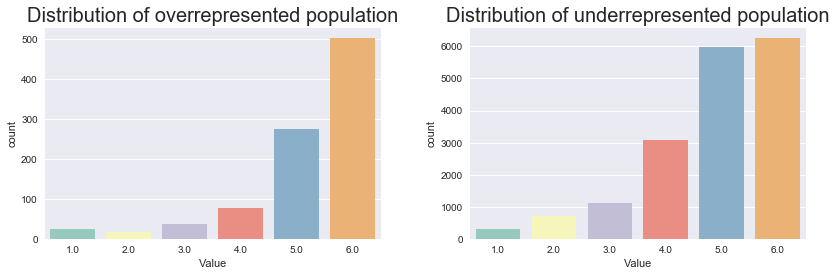

In [92]:

plot_comparison('HH_EINKOMMEN_SCORE')

In [93]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented_columns = []
underrepresented_centroids = []
for item in underrepresented_customers:
    underrepresented_centroids.append(reconstruct_original_dataspace(model_k.cluster_centers_[item[0]]))
    underrepresented_columns.append("centroid_"+str(item[0]))

underrepresented_d = pd.DataFrame(underrepresented_centroids, columns =  cleaned_customers.columns , index = underrepresented_columns )

underrepresented_d= underrepresented_d.transpose().round(2)
print(underrepresented_d)

customers.head

                            centroid_6
ALTER_HH                          7.30
ALTERSKATEGORIE_FEIN             10.55
ANZ_HAUSHALTE_AKTIV              11.65
ANZ_PERSONEN                      1.31
ANZ_STATISTISCHE_HAUSHALTE       10.85
BALLRAUM                          3.65
CJT_GESAMTTYP                     2.79
CJT_KATALOGNUTZER                 4.27
CJT_TYP_1                         2.20
CJT_TYP_2                         2.11
CJT_TYP_3                         4.15
CJT_TYP_4                         4.24
CJT_TYP_5                         4.18
CJT_TYP_6                         4.25
D19_BANKEN_ANZ_12                 0.02
D19_BANKEN_ANZ_24                 0.04
D19_BANKEN_DATUM                  9.80
D19_BANKEN_DIREKT                 0.34
D19_BANKEN_GROSS                  0.21
D19_BANKEN_LOKAL                  0.03
D19_BANKEN_OFFLINE_DATUM          9.99
D19_BANKEN_ONLINE_DATUM           9.88
D19_BANKEN_ONLINE_QUOTE_12        0.24
D19_BANKEN_REST                   0.12
D19_BEKLEIDUNG_GEH       

<bound method NDFrame.head of            LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0         9626         2         1.0      10.0          NaN          NaN   
1         9628        -1         9.0      11.0          NaN          NaN   
2       143872        -1         1.0       6.0          NaN          NaN   
3       143873         1         1.0       8.0          NaN          NaN   
4       143874        -1         1.0      20.0          NaN          NaN   
5       143888         1         1.0      11.0          NaN          NaN   
6       143904         2         1.0      10.0          NaN          NaN   
7       143910         1         1.0      10.0          NaN          NaN   
8       102160         2         3.0       5.0          NaN          NaN   
9       102173         1         1.0      20.0          NaN          NaN   
10      102184        -1         7.0      14.0          NaN          NaN   
11      102185         1         1.0      10.0          Na

### Discussion 3.3: Compare Customer Data to Demographics Data
As a result of transforming the customer data with the scaled, cluster fited demographic data, Some consistent conclusions can be made on the characteristics of the overrepresented and underrepresented clusters as follows:

Overrepresented vs underrepresented Clusters
The above charts informs us of the difference in individuals' share of upper-class cars for instance. The cluster overrepresented by customers has a minimal number of persons with upper-class car shares below the average, unlike the underrepresented cluster with a larger number of persons with upper-class car shares below the average. 
In terms of age distribution, 45 years old or lesser people are highly probable to become a customer in Arvato industries, unlike the elderly, aging from 46 years and above. These are just two out of the total 260 features, each of which could be compared against each group. 

Nonetheless, the estimated age from both overrepresented and underrepresented all fall among 46 to 60 years old. Also, the gender (ANDRE_KZ) does vary throughtout each group.   

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [94]:
mailout_train = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str', 19:'str'})
mailout_test = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str', 19:'str'})

In [95]:
# Get y_train from training data
y_response = mailout_train['RESPONSE']
del mailout_train['RESPONSE']
len_train, len_test = mailout_train.shape[0], mailout_test.shape[0]
# Concat train and test data
combined_df = pd.concat([mailout_train, mailout_test])

In [96]:
%%time
# Apply Data Cleaning to the dataset
# Note: clean_data_2 is different from clean_data_1
combined_df = clean_kaggle_data(combined_df)

Missing values for CAMER_DEUG, CAMEO_DEU and CAMEO_INTL done...
Shape after droping columns is (85795, 359)
Missing values dropped only by columns done...
ANZ_KINDER, ANZ_HH_TITEL and ANZ_TITEL droped because they have too many zero values ...
LNR LP_FAMILIE_GROB,LP_LEBENSPHASE_GROB, LP_STATUS_GROB, EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE droped ...
Praegende_jugendjahre feature engineering done ..
CAMEO_INTL_2015 feature engineering done...


C:\Users\ntsaku\Documents\DSND term2\capstone\helper.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_encoded["WOHNLAGE"][df_encoded["WOHNLAGE"]==7] = np.nan
C:\Users\ntsaku\Documents\DSND term2\capstone\helper.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_encoded["WOHNLAGE"][df_encoded["WOHNLAGE"]==8] = np.nan


numerical encoding finished...
Categorical encoding of PLZ8_BAUMAX, ARBEIT, AKT_DAT_KL, OST_WEST_KZ, CAMEO_DEU_2015, CAMEO_DEUG_2015  done...
Imputation finished...
Wall time: 4.98 s


In [97]:
scaler = StandardScaler()
scaler.fit(combined_df)
scaled_combined_df = scaler.transform(combined_df)

In [98]:
print(combined_df.shape)
combined_df.head()

(85795, 421)


,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,...,CAMEO_DEU_2015_9E,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
0,8.0,8.0,15.0,1.0,13.0,5.0,2.0,5.0,2.0,2.0,...,0,0,0,0,0,1,0,0,0,0
1,13.0,13.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,2.0,...,0,0,0,0,0,1,0,0,0,0
2,9.0,7.0,0.0,0.0,1.0,1.0,4.0,5.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,6.0,6.0,4.0,2.0,4.0,2.0,2.0,5.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,9.0,9.0,53.0,1.0,44.0,4.0,6.0,5.0,1.0,2.0,...,0,0,0,0,0,0,0,1,0,0


In [99]:
print(scaled_combined_df.shape)
scaled_combined_df

(85795, 421)


array([[-0.40532194, -0.4650828 ,  0.60896848, ..., -0.27570863,
        -0.36585466, -0.24523433],
       [ 0.49039769,  0.79952477, -0.4216901 , ..., -0.27570863,
        -0.36585466, -0.24523433],
       [-0.22617801, -0.71800431, -0.49530857, ..., -0.27570863,
        -0.36585466, -0.24523433],
       ..., 
       [ 1.02782946,  1.3053678 , -0.4216901 , ..., -0.27570863,
        -0.36585466, -0.24523433],
       [-1.83847334, -2.48845491, -0.4216901 , ..., -0.27570863,
        -0.36585466, -0.24523433],
       [ 0.66954161,  1.05244628, -0.4216901 , ..., -0.27570863,
         2.73332587, -0.24523433]])

In [112]:
#split dataset to train and test
train_mailout = scaled_combined_df[:len_train]
test_mailout = scaled_combined_df[len_train:]


In [113]:
#split data into train, validation, test
X_train, X_test, y_train, y_test = train_test_split(train_mailout, y_response, stratify=y_response, test_size=0.2)

### Supervised Learning with Gradient Boosting Classifier

In [102]:
%%time
best_pred = GBC_test(X_train, X_test, y_train, y_test)

Wall time: 0 ns


### Result with gradient boosting classifier
Unoptimized model
ROC score on testing data: 0.7510

Optimized Model
ROC score on testing data: 0.4996

{'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_split': 4, 'gradientboostingclassifier__n_estimators': 100}


### Supervised Learning with Light Gadient Boost Machine

Unoptimized model
------
ROC score on testing data: 0.6505

Optimized Model
------
ROC score on testing data: 0.7225

------
{'learning_rate': 0.001, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1000}


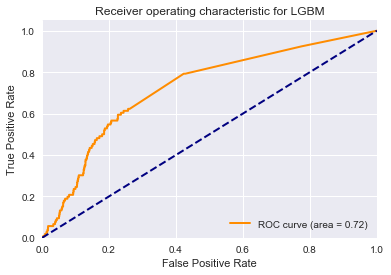

Wall time: 1h 32min 12s


In [114]:
%%time
# basic training using LGBMRegressor
best_pred = LightGBM_test(X_train, X_test, y_train, y_test)

### Results with Light Gradient Boost Machine
Unoptimized model
ROC score on testing data: 0.6353

Optimized Model
ROC score on testing data: 0.7503

{'learning_rate': 0.001, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1000}
Wall time: 54min 13s


### Supervised Learning with XGBoost Regressor

Unoptimized model
------
ROC score on testing data: 0.7728

Optimized Model
------
ROC score on testing data: 0.7428

------
{'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 200}


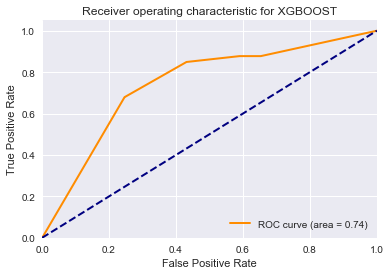

Wall time: 36.7 s


In [104]:
%%time
# basic training using LGBMRegressor
best_pred = XGBoost_test(X_train, X_test, y_train, y_test)

### Results with XGBoost Regressor
Unoptimized model
ROC score on testing data: 0.7816

Optimized Model
ROC score on testing data: 0.7741

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Wall time: 2h 3min 56s

## supervised learning with keras neural network
### Create a basic neural network
- 64 relu -> 128 relu -> dropout 0.15
-  -> 64 relu -> dropout 0.15 -> softmax 10
- Optimizer ==> RMSprop
- Loss      ==> categorical-crossentropy

In [105]:
#supervised learning with keras neural network
# Create a basic neural network
# 64 relu -> 128 relu -> dropout 0.15
# -> 64 relu -> dropout 0.15 -> softmax 10
#Optimizer ==> RMSprop
#Loss      ==> categorical-crossentropy
model=Sequential()
model.add(Dense(64,activation='relu',input_dim=(421)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(2,activation=tf.nn.softmax))

model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [106]:
#Split data into train and validation
y_binary = to_categorical(y_response, dtype='int32', num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(train_mailout, y_binary, stratify=y_response, test_size=0.2)
#fit dataset on model with 15 steps, 90% training and 10% cross validation 
history=model.fit(X_train, y_train, validation_split = 0.2, 
            epochs=15, batch_size=10)
#history.history

Train on 27495 samples, validate on 6874 samples
Epoch 1/15
27495/27495 [==============================] - 5s 166us/step - loss: 0.0979 - acc: 0.9872 - val_loss: 0.1130 - val_acc: 0.9860
Epoch 2/15
27495/27495 [==============================] - 4s 128us/step - loss: 0.0949 - acc: 0.9878 - val_loss: 0.1048 - val_acc: 0.9860
Epoch 3/15
27495/27495 [==============================] - 4s 137us/step - loss: 0.1035 - acc: 0.9878 - val_loss: 0.1286 - val_acc: 0.9860
Epoch 4/15
27495/27495 [==============================] - 4s 133us/step - loss: 0.1111 - acc: 0.9877 - val_loss: 0.1277 - val_acc: 0.9860
Epoch 5/15
27495/27495 [==============================] - 3s 125us/step - loss: 0.1114 - acc: 0.9871 - val_loss: 0.1619 - val_acc: 0.9859
Epoch 6/15
27495/27495 [==============================] - 3s 124us/step - loss: 0.1273 - acc: 0.9868 - val_loss: 0.1419 - val_acc: 0.9857
Epoch 7/15
27495/27495 [==============================] - 4s 132us/step - loss: 0.1305 - acc: 0.9868 - val_loss: 0.1298 - v

In [107]:
#Collect back Y target 1D class
train_mailout = scaled_combined_df[:len_train]
test_mailout = scaled_combined_df[len_train:]
#split data into train, validation, test
_, _, _, y_test = train_test_split(train_mailout, y_response, stratify=y_response, test_size=0.2)

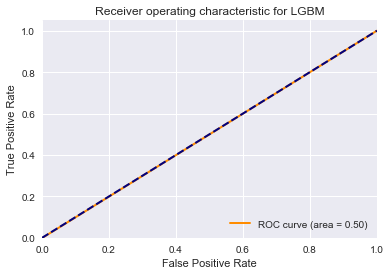

In [108]:
y_pred = model.predict_classes(X_test)

roc_auc_score(y_test, y_pred)

#PLOT ROC
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2

plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for LGBM')
plt.legend(loc="lower right")
plt.show()

##  Results examination with Neural Nets 
ROC score is so low using the Neural Network because the response variable class is unbalanced with just 532 customers out of 42,962 sample persons.
The response class is imbalanced, therebyproducing an ROC score of 0.5, though the validation accuracy is 0.98. This shows how biased the model is to the majority class. Two solutions to this would be Undersampling the majority class, or Oversampling the minority class.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [109]:
mailout_test = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';',dtype={18:'str', 19:'str'})

In [ ]:
#test_preds, importances = training_1(train_data, test_data, y_reg)
#print_importances(importances)
best_test_predictions = best_clf.predict(test_mailout)

In [ ]:
best_test_predictions

In [ ]:
results = pd.read_csv('./arvato_data/Arvato_Capstone_Example_Submission.csv')
results.RESPONSE = best_test_predictions
results.to_csv('./arvato_data/results.csv', index=False)